# Back-Testing Simulator

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import os
from utils.util import get_data, plot_data, get_bollinger_bands, get_portfolio_stats
import matplotlib.pyplot as plt
from itertools import izip
%matplotlib inline

### Initialization

In [2]:
date_start = '2007-12-31'
date_end = '2009-12-31'
folder_strategy = 'out'
file_strategy = 'bollingerstrategy' 

dates = pd.date_range(date_start, date_end)
file_name = os.path.join(folder_strategy, '{}.csv'.format(file_strategy))
events = True

### Load Data

In [3]:
# Load orders
orders = pd.read_csv(file_name, index_col=0, parse_dates=True)
stock = orders.ix[0]['Symbol'] 
orders.head()

,Symbol,Order,Shares,Price
Date,,,,
2008-02-28,IBM,SELL SHORT,100,106.24
2008-03-27,IBM,EXIT SHORT,100,106.49
2008-04-22,IBM,SELL SHORT,100,114.01
2008-05-21,IBM,EXIT SHORT,100,114.43
2008-07-01,IBM,BUY LONG,100,110.40


In [4]:
# Load stock data and join orders in the same DataFrame 
prices_all = get_data([stock], dates)
df = prices_all[[stock]]
df = df.join(orders[['Order', 'Shares']])
df.head()

,IBM,Order,Shares
2007-12-31,99.27,NaN,NaN
2008-01-02,96.14,NaN,NaN
2008-01-03,96.34,NaN,NaN
2008-01-04,92.87,NaN,NaN
2008-01-07,91.88,NaN,NaN


### Back-Testing

In [5]:
df['daily_val'] = 0.0
df['shorting'] = 1.0
hold = False
shorting = False

# Compute portfolio daily value
for i, row in df.iterrows():
    
    if (row['Order'] == 'BUY LONG') | (row['Order'] == 'SELL SHORT'):
        hold = True
        n_stocks = row['Shares']
        if row['Order'] == 'SELL SHORT':
            shorting = True            
    
    if hold == True:
        df.loc[i, 'Shares'] = n_stocks # replicate shares when stock is hold
        df.loc[i, 'daily_val'] = n_stocks * row[stock]
        if shorting:
            df.loc[i, 'shorting'] = -1.0
                    
    if (row['Order'] == 'EXIT LONG') | (row['Order'] == 'EXIT SHORT'):
        hold = False
        shorting = False
        
# Compute daily returns
df['daily_return'] = df['daily_val'].diff()   
df['daily_return'] = df['daily_return'] * df['shorting']
# Reset to 0 NaN and not valid daily_returns  
df.ix[0, 'daily_return'] = 0
for (index1, row1),(index2, row2) in izip(df.iterrows(), df[1:].iterrows()):
    if np.isnan(row1['Shares']) or np.isnan(row2['Shares']):
        df.loc[index2, 'daily_return'] = 0.0
df['cum_return'] = df['daily_return'].cumsum()

# Compute cumulative portfolio value
T0 = df[~pd.isnull(df['Order'])].index[0] # Timestamp @ first investment 
Val0 = df.ix[T0]['daily_val'] # Initial portfolio value
df['port_val'] = df['cum_return'] + Val0

df.head()      

,IBM,Order,Shares,daily_val,shorting,daily_return,cum_return,port_val
2007-12-31,99.27,NaN,NaN,0.0,1.0,0.0,0.0,10624.0
2008-01-02,96.14,NaN,NaN,0.0,1.0,0.0,0.0,10624.0
2008-01-03,96.34,NaN,NaN,0.0,1.0,0.0,0.0,10624.0
2008-01-04,92.87,NaN,NaN,0.0,1.0,0.0,0.0,10624.0
2008-01-07,91.88,NaN,NaN,0.0,1.0,0.0,0.0,10624.0


In [6]:
# Write DataFrame to csv
# df.to_csv('DataFrane.csv')

### Print Results

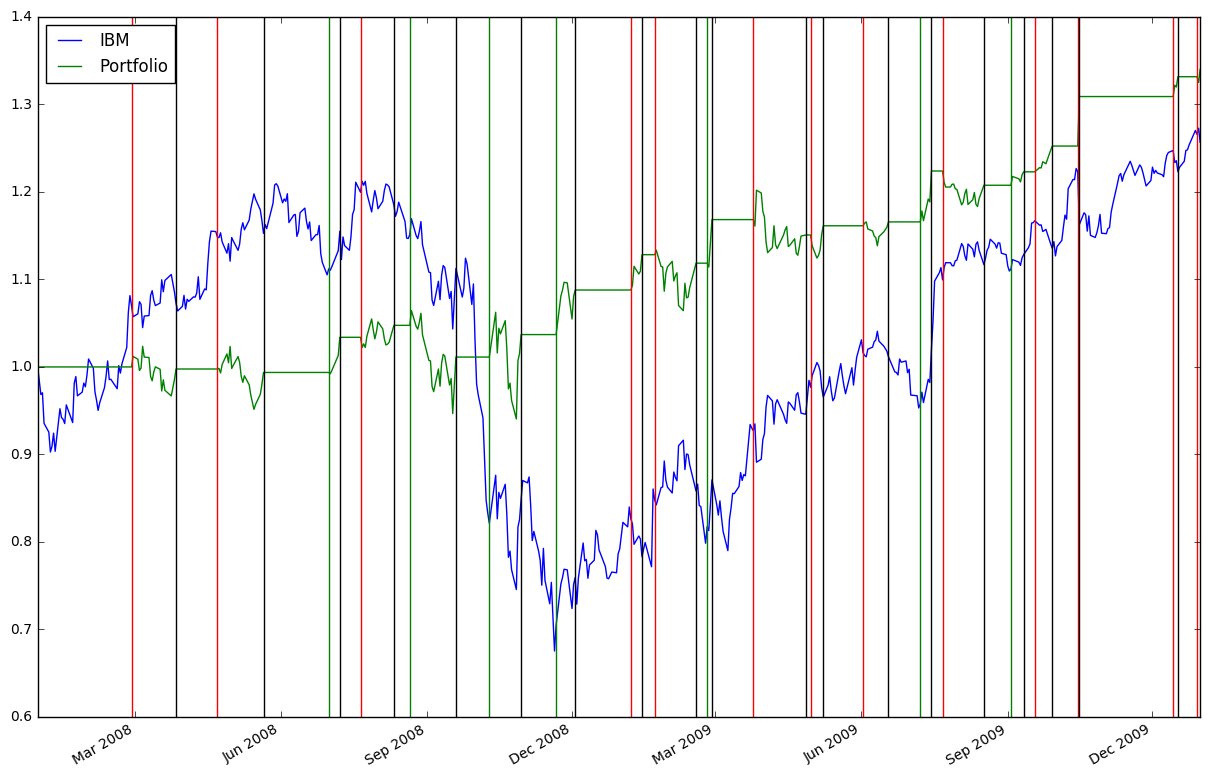

Cumulative Return of Fund: 0.340173192771
Cumulative Return of IBM: 0.256774453511

Standard Deviation of Fund: 0.0102601272229
Standard Deviation of IBM: 0.0203041081387

Average Daily Return of Fund: 0.000631156047906
Average Daily Return of IBM: 0.000656435557614

Sharpe Ratio of Fund: 0.97652703809
Sharpe Ratio of IBM: 0.513225764555

Initial Portfolio Value: 10624.0
Final Portfolio Value: 14238.0
Final Portfolio Return: 3614.0
Final IBM Return: 2549.0


In [7]:
# Plot Section
df_temp = pd.concat([df[stock]/df.ix[0][stock], df['port_val']/df.ix[T0]['port_val']], keys=[stock, 'Portfolio'], axis=1)
ax = df_temp.plot(figsize=(15, 10))
# Plot events
if events:
    for day, key in orders.iterrows():
        if key['Order'] == 'BUY LONG':
            ax.axvline(x=day, color='green')
        elif key['Order'] == 'SELL SHORT':
            ax.axvline(x=day, color='red')
        elif (key['Order'] == 'EXIT LONG') | (key['Order'] == 'EXIT SHORT'):
            ax.axvline(x=day, color='black')
plt.show()        

# Compute Stats Sections
sharpe_ratio, cum_ret, avg_daily_ret, std_daily_ret = get_portfolio_stats(df['port_val'])
sharpe_ratio_stock, cum_ret_stock, avg_daily_ret_stock, std_daily_ret_stock = get_portfolio_stats(df[stock])

# Compare portfolio against stock
print "Cumulative Return of Fund: {}".format(cum_ret)
print "Cumulative Return of {}: {}".format(stock, cum_ret_stock)
print
print "Standard Deviation of Fund: {}".format(std_daily_ret)
print "Standard Deviation of {}: {}".format(stock, std_daily_ret_stock)
print
print "Average Daily Return of Fund: {}".format(avg_daily_ret)
print "Average Daily Return of {}: {}".format(stock, avg_daily_ret_stock)
print
print "Sharpe Ratio of Fund: {}".format(sharpe_ratio)
print "Sharpe Ratio of {}: {}".format(stock, sharpe_ratio_stock)
print
print "Initial Portfolio Value: {}".format(df['port_val'][0])
print "Final Portfolio Value: {}".format(df['port_val'][-1])
print "Final Portfolio Return: {}".format(df['cum_return'][-1])
print "Final {} Return: {}".format(stock, (df[stock][-1]-df[stock][0])*n_stocks)